In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
base_skin_dir = os.path.join('download_data')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
skin_df = pd.read_csv('HAM10000_metadata.csv')

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,download_data\HAM10000_images_part_1\ISIC_0027...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,download_data\HAM10000_images_part_1\ISIC_0025...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,download_data\HAM10000_images_part_1\ISIC_0026...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,download_data\HAM10000_images_part_1\ISIC_0025...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,download_data\HAM10000_images_part_2\ISIC_0031...,Benign keratosis-like lesions,2


In [6]:
skin_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [7]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [8]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [9]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


In [10]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [11]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,download_data\HAM10000_images_part_1\ISIC_0027...,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,download_data\HAM10000_images_part_1\ISIC_0025...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,download_data\HAM10000_images_part_1\ISIC_0026...,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,download_data\HAM10000_images_part_1\ISIC_0025...,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,download_data\HAM10000_images_part_2\ISIC_0031...,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


In [12]:
np.all(skin_df['image'][0] == 0)

False

In [13]:
def remove_dups(df, subset=None, index=False):
    """
    Drop all for EXTRA occurences. 
    Arguments:
        ``subset`` - column label or sequence of labels, optional
            Only consider certain columns for identifying duplicates, by default use all of the columns
        ``index`` - True or False; default False.
            Whether you want to duplication to be judged solely on the index.
    """
    if index: dedup_tf = df.index.duplicated(subset=subset, keep='first') #returns an array with T/F for EXTRA occurences of dates
    else: dedup_tf = df.duplicated(subset=subset, keep='first') #returns an array with T/F for EXTRA occurences of dates
    dedup_indx = np.where(dedup_tf == False) #record non-duplicate indices
    return df.iloc[dedup_indx] #slice df by indicies

In [14]:
skin_df_dd = remove_dups(skin_df, subset='lesion_id').copy()

In [15]:
#check for duplicate image_ids
skin_df_dd['lesion_id'].value_counts().head()

HAM_0005381    1
HAM_0002160    1
HAM_0004590    1
HAM_0002102    1
HAM_0003768    1
Name: lesion_id, dtype: int64

In [16]:
#order by diagnosis
skin_df_dd.sort_values(by=['dx'], inplace=True)

In [17]:
#look at the existing abbreviations and choose two
set(skin_df_dd['dx'])

{'akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'}

In [35]:
#grab 20 images from 2 classes for the training set
akiec = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='akiec')[0][0:266], :] 
bcc = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='bcc')[0][0:410], :] 
nv = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='nv')[0][0:5364], :] 
mel = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='mel')[0][0:889], :] 
bkl = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='bkl')[0][0:878], :] 
vasc = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='vasc')[0][0:142], :] 
df = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='df')[0][0:92], :] 

In [20]:
#concatonate them
train = pd.concat([akiec, bcc, nv, mel, bkl, vasc, df])
train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,download_data\HAM10000_images_part_2\ISIC_0033...,Actinic keratoses,0,"[[[172, 155, 165], [170, 148, 160], [153, 139,..."
9783,HAM_0002648,ISIC_0027650,akiec,histo,40.0,male,neck,download_data\HAM10000_images_part_1\ISIC_0027...,Actinic keratoses,0,"[[[179, 131, 147], [175, 131, 146], [173, 131,..."
9782,HAM_0001967,ISIC_0029860,akiec,histo,85.0,male,chest,download_data\HAM10000_images_part_2\ISIC_0029...,Actinic keratoses,0,"[[[212, 169, 189], [201, 148, 168], [207, 180,..."
9781,HAM_0000859,ISIC_0029715,akiec,histo,70.0,male,lower extremity,download_data\HAM10000_images_part_2\ISIC_0029...,Actinic keratoses,0,"[[[194, 170, 194], [188, 164, 188], [190, 164,..."
9780,HAM_0002441,ISIC_0030491,akiec,histo,80.0,male,scalp,download_data\HAM10000_images_part_2\ISIC_0030...,Actinic keratoses,0,"[[[177, 126, 122], [172, 118, 118], [175, 122,..."


In [21]:
#grab 200 images from 2 classes for the test set
akiec_test = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='akiec')[0][266:327], :] 
bcc_test = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='bcc')[0][410:514], :] 
nv_test = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='nv')[0][5354:6705], :] 
mel_test = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='mel')[0][889:1113], :] 
bkl_test = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='bkl')[0][878:1099], :] 
vasc_test = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='vasc')[0][113:142], :] 
df_test = skin_df_dd.iloc[np.where(skin_df_dd['dx']=='df')[0][92:115], :] 

In [23]:
#concatonate them
test = pd.concat([akiec_test, bcc_test, nv_test, mel_test, bkl_test, vasc_test, df_test])
test.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
4861,HAM_0001746,ISIC_0027296,nv,follow_up,65.0,female,lower extremity,download_data\HAM10000_images_part_1\ISIC_0027...,Melanocytic nevi,4,"[[[228, 145, 171], [226, 148, 172], [231, 147,..."
4860,HAM_0003240,ISIC_0026387,nv,follow_up,65.0,female,lower extremity,download_data\HAM10000_images_part_1\ISIC_0026...,Melanocytic nevi,4,"[[[223, 136, 171], [214, 128, 157], [225, 131,..."
4859,HAM_0006141,ISIC_0024603,nv,follow_up,65.0,female,lower extremity,download_data\HAM10000_images_part_1\ISIC_0024...,Melanocytic nevi,4,"[[[227, 144, 162], [228, 146, 169], [230, 140,..."
4858,HAM_0006356,ISIC_0029732,nv,follow_up,65.0,female,back,download_data\HAM10000_images_part_2\ISIC_0029...,Melanocytic nevi,4,"[[[227, 141, 166], [225, 144, 163], [230, 137,..."
4866,HAM_0004741,ISIC_0031687,nv,follow_up,65.0,male,upper extremity,download_data\HAM10000_images_part_2\ISIC_0031...,Melanocytic nevi,4,"[[[211, 128, 138], [214, 121, 140], [215, 123,..."


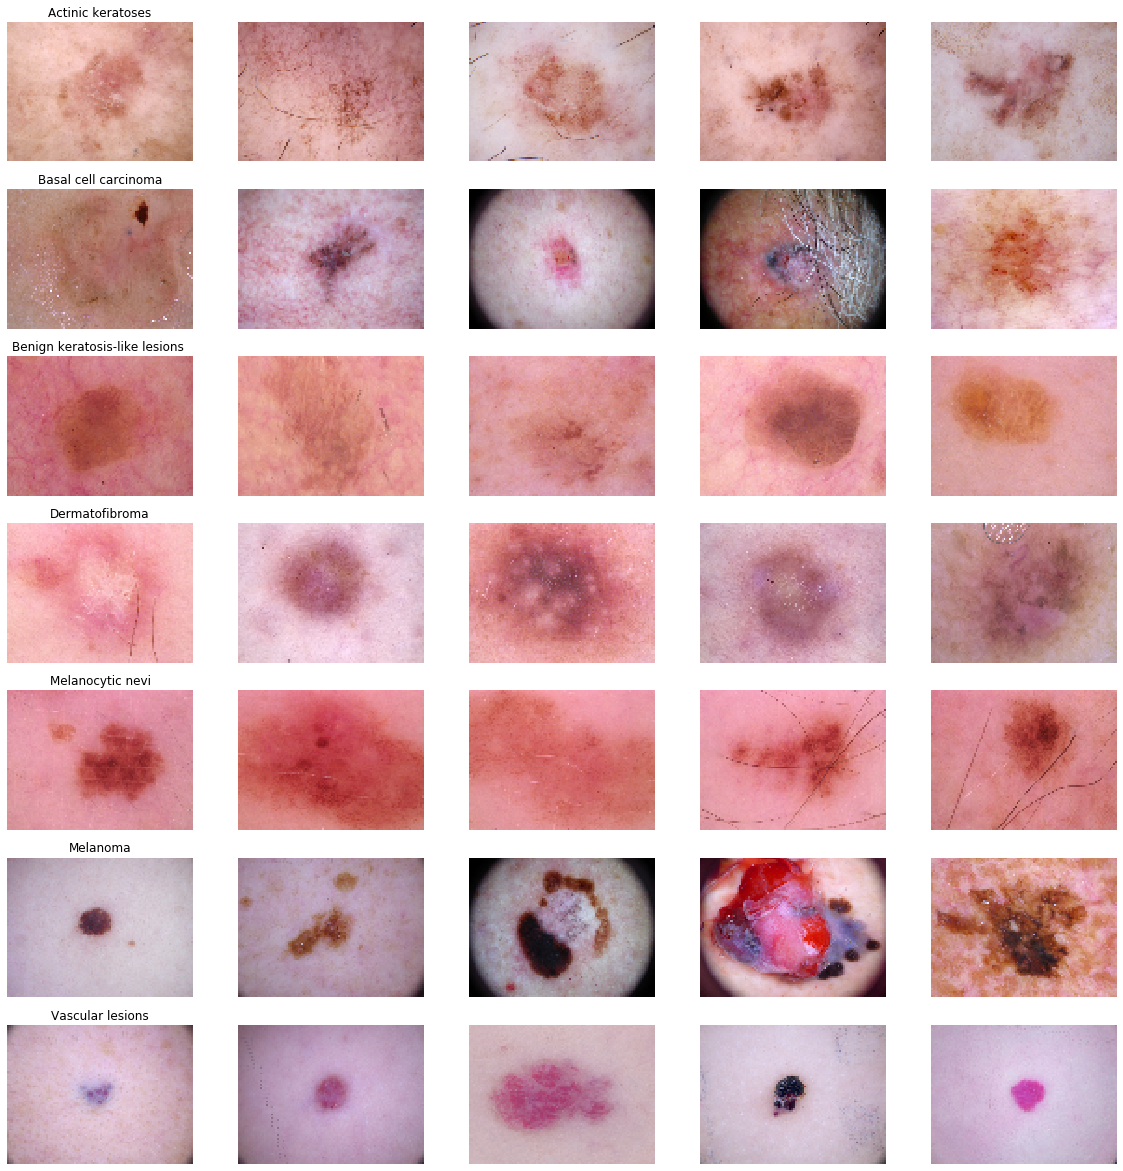

In [219]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         train.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [220]:
# Checking the image size distribution
train['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    350
Name: image, dtype: int64

In [221]:
#split x and y columns
x_train = train.drop(columns=['cell_type_idx'],axis=1)
y_train = train['cell_type_idx']

x_test = test.drop(columns=['cell_type_idx'],axis=1)
y_test = test['cell_type_idx']

In [222]:
x_train_arr = np.asarray(x_train['image'].tolist())
x_test_arr = np.asarray(x_test['image'].tolist())

In [223]:
x_train_arr[38]

array([[[203, 156, 166],
        [205, 158, 168],
        [205, 152, 168],
        ...,
        [210, 176, 203],
        [210, 175, 205],
        [209, 168, 198]],

       [[206, 153, 169],
        [204, 152, 165],
        [206, 153, 163],
        ...,
        [210, 176, 203],
        [209, 175, 202],
        [210, 173, 204]],

       [[207, 164, 181],
        [205, 163, 173],
        [204, 149, 152],
        ...,
        [213, 178, 208],
        [211, 178, 205],
        [208, 174, 199]],

       ...,

       [[201, 145, 172],
        [203, 147, 176],
        [204, 148, 177],
        ...,
        [207, 154, 180],
        [208, 154, 180],
        [207, 153, 177]],

       [[198, 144, 170],
        [196, 130, 157],
        [201, 142, 170],
        ...,
        [203, 158, 178],
        [209, 161, 177],
        [203, 158, 179]],

       [[199, 136, 165],
        [198, 141, 160],
        [186, 127, 133],
        ...,
        [200, 159, 177],
        [204, 162, 186],
        [200, 158, 172]]

In [224]:
for j in range(len(x_train_arr)):
    print(j, x_train_arr[j])

0 [[[172 155 165]
  [170 148 160]
  [153 139 154]
  ...
  [206 192 189]
  [211 193 189]
  [203 185 183]]

 [[193 178 199]
  [201 176 205]
  [199 182 200]
  ...
  [215 195 204]
  [223 197 206]
  [214 194 193]]

 [[197 180 198]
  [200 181 203]
  [199 181 197]
  ...
  [214 198 199]
  [222 201 200]
  [220 197 203]]

 ...

 [[205 184 199]
  [211 182 186]
  [207 184 194]
  ...
  [213 191 193]
  [205 189 190]
  [202 187 190]]

 [[203 176 185]
  [203 177 188]
  [213 190 196]
  ...
  [203 192 190]
  [205 184 191]
  [207 186 191]]

 [[211 187 200]
  [212 186 197]
  [212 192 203]
  ...
  [204 186 184]
  [203 180 188]
  [202 183 187]]]
1 [[[179 131 147]
  [175 131 146]
  [173 131 145]
  ...
  [180 102 126]
  [181 113 134]
  [179 117 138]]

 [[178 131 149]
  [175 133 147]
  [179 131 147]
  ...
  [178 110 133]
  [180 106 131]
  [182 117 139]]

 [[183 129 152]
  [180 137 154]
  [179 135 152]
  ...
  [181 117 141]
  [176 102 127]
  [182 114 137]]

 ...

 [[180 131 153]
  [182 135 151]
  [180 132 154]


  [16 10 14]]]
71 [[[180 166 192]
  [175 161 187]
  [186 174 198]
  ...
  [210 212 224]
  [209 211 223]
  [205 207 222]]

 [[185 171 197]
  [184 168 195]
  [183 174 195]
  ...
  [206 212 226]
  [214 206 227]
  [202 200 221]]

 [[183 173 197]
  [185 178 196]
  [188 173 192]
  ...
  [205 206 224]
  [204 202 223]
  [205 202 221]]

 ...

 [[193 183 192]
  [188 178 189]
  [186 176 185]
  ...
  [201 202 220]
  [203 204 222]
  [199 201 214]]

 [[194 184 195]
  [190 180 188]
  [188 175 184]
  ...
  [195 203 216]
  [201 204 219]
  [202 204 217]]

 [[198 188 199]
  [192 182 193]
  [189 183 193]
  ...
  [205 204 220]
  [207 206 222]
  [204 203 221]]]
72 [[[147 116 114]
  [149 115 114]
  [144 110 108]
  ...
  [208 178 180]
  [206 180 181]
  [213 187 188]]

 [[139 106 101]
  [146 112 110]
  [149 116 111]
  ...
  [204 170 171]
  [216 185 190]
  [215 188 193]]

 [[143 110 105]
  [145 110 106]
  [142 109 104]
  ...
  [212 180 181]
  [214 186 183]
  [219 194 197]]

 ...

 [[165 140 136]
  [165 140 135]

  [199 130 125]]]
139 [[[230 153 173]
  [231 149 172]
  [229 147 170]
  ...
  [237 154 174]
  [235 159 171]
  [235 162 179]]

 [[226 149 169]
  [230 151 172]
  [231 148 168]
  ...
  [234 153 170]
  [226 152 165]
  [241 158 174]]

 [[228 151 171]
  [224 150 163]
  [229 145 161]
  ...
  [233 152 167]
  [230 153 173]
  [233 152 169]]

 ...

 [[206 130 143]
  [212 136 146]
  [212 136 149]
  ...
  [216 145 153]
  [210 144 148]
  [212 146 148]]

 [[203 129 142]
  [209 132 142]
  [208 134 147]
  ...
  [214 144 155]
  [207 145 148]
  [215 145 153]]

 [[208 132 145]
  [209 133 145]
  [210 132 146]
  ...
  [215 146 151]
  [216 151 157]
  [223 162 161]]]
140 [[[232 159 168]
  [235 158 168]
  [233 156 166]
  ...
  [231 154 164]
  [232 152 165]
  [234 153 168]]

 [[234 158 170]
  [236 155 174]
  [235 155 166]
  ...
  [224 151 158]
  [229 155 168]
  [225 149 159]]

 [[229 153 166]
  [235 155 166]
  [233 156 172]
  ...
  [231 153 167]
  [235 158 168]
  [226 148 161]]

 ...

 [[208 145 138]
  [215 143

In [227]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [228]:
y_train[:5,:]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [229]:
y_train[-6:-1,:]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [230]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train_arr)

In [254]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 25, 64)       

In [255]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [256]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["acc"])

In [257]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [258]:
learning_rate_reduction

In [262]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

num_classes = 7
resnet_weights_path = 'resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet_weights_path

'resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [263]:
my_new_model = Sequential()
my_new_model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
my_new_model.add(Dense(num_classes, activation='softmax'))

In [264]:
# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[0].trainable = False

In [265]:
#compile model
my_new_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [266]:
#fit model
epochs = 50 
batch_size = 10

history = my_new_model.fit(datagen.flow(x_train_arr, y_train, batch_size=batch_size),
                           verbose = 0,
                           epochs = epochs,
                           steps_per_epoch=x_train.shape[0] // batch_size,
                           validation_data = (x_test_arr, y_test)
                          )

  ...
    to  
  ['...']


In [267]:
hist.history

{'loss': [1.1431006044149399,
  0.7579082995653152,
  0.6246477961540222,
  0.4597993493080139,
  0.4607437625527382,
  0.4588368460536003,
  0.3032120652496815,
  0.41451892256736755,
  0.21400552988052368,
  0.27159261889755726,
  0.24439195729792118,
  0.24603858403861523,
  0.21018807590007782,
  0.21362041682004929,
  0.213377945125103,
  0.14449492283165455,
  0.20594902150332928,
  0.24057162925601006,
  0.12974024564027786,
  0.19099379144608974,
  0.19687704741954803,
  0.2376134917140007,
  0.14214335940778255,
  0.10058755241334438,
  0.22136784438043833,
  0.11069572810083628,
  0.1161843091249466,
  0.19420631788671017,
  0.12247927300632,
  0.0773346503265202,
  0.12527278624475002,
  0.10039406642317772,
  0.11078745778650045,
  0.14116405881941319,
  0.09869213029742241,
  0.08128075394779444,
  0.06287377700209618,
  0.12732030544430017,
  0.11041257483884692,
  0.13850482180714607,
  0.08595896791666746,
  0.06957400729879737,
  0.0652673039585352,
  0.096329449675977

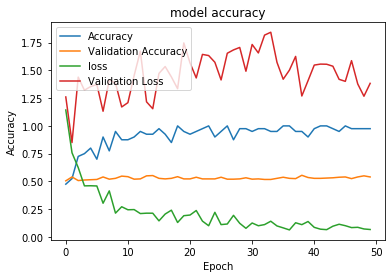

In [268]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [269]:
print("Training Accuracy: ", hist.history["accuracy"][len(hist.history["accuracy"])-1])
print("Validation Accuracy: ", hist.history["val_accuracy"][len(hist.history["val_accuracy"])-1])
print("Loss: ", hist.history["loss"][len(hist.history["loss"])-1])
print("Validation Loss: ", hist.history["val_loss"][len(hist.history["val_loss"])-1])

Training Accuracy:  0.975
Validation Accuracy:  0.54
Loss:  0.06659152777865529
Validation Loss:  1.3833738934248685
